In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pickle
import h5py

import librosa
import librosa.display

from dotenv import load_dotenv
from my_functions.my_fun import *


In [54]:
load_dotenv()

META_DIR = os.getenv('PMEMO_META')
aux_dir = META_DIR.split('.')[0]
META_DIR =f'{aux_dir}_total.csv'

ANOTATION_DIR = os.getenv('PMEMO_ANOTATIONS')
ANOTATION_DIR = os.path.join(ANOTATION_DIR,'agumented.csv')

ASSETS_DIR = os.getenv('ASSETS_DIR')

In [3]:
if not os.path.exists(META_DIR):
    print('El archivo con la meta información no existe')
    
if not os.path.exists(ANOTATION_DIR):
    print('El archivo con anotaciones no existe')

# Cargar audios y metadatos

In [4]:
pmemo_meta = pd.read_csv(META_DIR)
pmemo_meta.head(5)


,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26
2,5,5.mp3,No Heart,21 Savage,Savage Mode,84.23,00:41,02:03
3,6,6.mp3,Red Opps,21 Savage,Red Opps,29.53,02:16,02:44
4,7,7.mp3,Girls Talk Boys,5 Seconds Of Summer,Ghostbusters (Original Motion Picture Soundtrack),29.11,02:30,02:57


In [5]:
labels_df = pd.read_csv(ANOTATION_DIR)
del labels_df['Unnamed: 0']
labels_df.describe()

,musicId,Arousal(mean),Valence(mean)
count,4602.000000,4602.000000,4602.000000
mean,493.770535,0.622355,0.596581
std,285.802745,0.184712,0.161898
min,1.000000,0.087500,0.125000
25%,238.000000,0.500000,0.487500
50%,495.000000,0.650000,0.625000
75%,740.000000,0.762500,0.725000
max,1000.000000,0.975000,0.912500


In [6]:
labels_df = labels_df.rename(columns={'Arousal(mean)':'Arousal',
                              'Valence(mean)':'Valence'})

labels_df['musicId'] = labels_df['musicId'].astype(int)

labels_df.tail(12)

,musicId,Arousal,Valence,isAugmented,info,audioDir
4590,999,0.8750,0.775,False,Source file,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4591,999,0.8750,0.775,True,Time stretching 0.81 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4592,999,0.8750,0.775,True,Time stretching 0.93 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4593,999,0.8750,0.775,True,Time stretching 1.07 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4594,999,0.8750,0.775,True,Time stretching 1.23 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4595,999,0.8750,0.775,True,Time shifting 5 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4596,1000,0.6625,0.575,False,Source file,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4597,1000,0.6625,0.575,True,Time stretching 0.81 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4598,1000,0.6625,0.575,True,Time stretching 0.93 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...
4599,1000,0.6625,0.575,True,Time stretching 1.07 seconds,E:\python_proy\mer\assets\PMEMO\PMEmo2019\chor...


In [7]:
audio_data = []
audios_dir = labels_df['audioDir'].values

start_time = time.time()
for i,audio in enumerate(audios_dir):
    y,sr = librosa.load(audio)
    
    audio_data.append([y,sr])

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Tiempo transcurrido en la carga de audios: {elapsed_time}')

Tiempo transcurrido en la carga de audios: 196.71806979179382


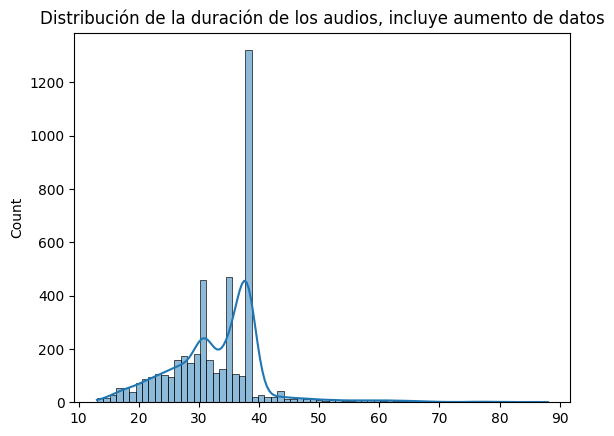

In [8]:
audio_data = np.array(audio_data, dtype='object')

sr_mean = int(np.mean(audio_data[:,1]))

y_list = audio_data[:,0]
y_len = np.array([len(y) for y in y_list])

show_distribution(data=y_len/sr_mean,title=f'Distribución de la duración de los audios, incluye aumento de datos')



# Generar Chromas

In [9]:
chromas_m = []
chromas_p = []

trunk = 1637

start_time = time.time()

for y,sr in audio_data:
    cp = get_chromagram(audio=y,sr=sr,power_spectrum=True,target_len = trunk)
    cm = get_chromagram(audio=y,sr=sr,target_len=trunk)
    
    chromas_m.append(cm)
    chromas_p.append(cp)

end_time = time.time()
elapsed_time = end_time-start_time
print(f'Tiempo transcurrido para la generación de chromagrams: {elapsed_time}')

Tiempo transcurrido para la generación de chromagrams: 1309.6485528945923


In [14]:
chromas_m = np.array(chromas_m)
print(chromas_m.shape)
chromas_p = np.array(chromas_p)
print(chromas_p.shape)

(4602, 12, 1637)
(4602, 12, 1637)


In [19]:
ex_chromas_m =chromas_m.copy()
ex_chromas_m = np.expand_dims(ex_chromas_m,axis=-1)
ex_chromas_m = np.repeat(ex_chromas_m,3,axis=-1)
print(f'chromas chromas_m expand dim: {ex_chromas_m.shape}')
print(ex_chromas_m[0].shape)

ex_chromas_p =chromas_p.copy()
ex_chromas_p = np.expand_dims(ex_chromas_p,axis=-1)
ex_chromas_p = np.repeat(ex_chromas_p,3,axis=-1)
print(f'chromas chromas_p expand dim: {ex_chromas_p.shape}')
print(ex_chromas_p[0].shape)

chromas chromas_m expand dim: (4602, 12, 1637, 3)
(12, 1637, 3)
chromas chromas_p expand dim: (4602, 12, 1637, 3)
(12, 1637, 3)


In [22]:
start_time = time.time()
res_chroma_m = resize_spectrogramas(ex_chromas_m,(224,224))
res_chroma_p = resize_spectrogramas(ex_chromas_p,(224,224))
end_time = time.time()
elapsed_time = end_time -start_time
print(f'Tiempo transcurrido para re dimensionar espectrogramas: {elapsed_time}')

Tiempo transcurrido para re dimensionar espectrogramas: 14.135875463485718


In [24]:
print(res_chroma_p.shape)
print(res_chroma_m.shape)

(4602, 224, 224, 3)
(4602, 224, 224, 3)


In [26]:
save_spectrograms(res_chroma_m,'chromas_magnitud_res_au','')
save_spectrograms(res_chroma_p,'chromas_power_res_au','')
save_spectrograms(chromas_m,'chromas_magnitud_au','')
save_spectrograms(chromas_p,'chromas_power_au','')

Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente


'chromas_power_au.pkl'

In [35]:
rnd_idx = np.random.randint(0,len(labels_df))
music_idx = labels_df.iloc[rnd_idx].musicId
display(pmemo_meta.loc[pmemo_meta['musicId'] == music_idx])
display(labels_df.iloc[rnd_idx].audioDir)

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
62,75,75.mp3,Rabbit Hole,Blink-182,Rabbit Hole,22.1,01:46,02:06


'E:\\python_proy\\mer\\assets\\PMEMO\\PMEmo2019\\chorus\\augmented\\75_tst2.mp3'

In [47]:
indices = np.arange(len(labels_df))

np.random.shuffle(indices)

# Calcula los tamaños para cada conjunto
train_size = int(0.6 * len(indices))
val_size = int(0.2 * len(indices))
test_size = len(indices) - train_size - val_size  # Para asegurar que se cubre todo


# Divide el array en entrenamiento, validación y prueba
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Entrenamiento: {len(train_indices)}")
print(f"Validación: {len(val_indices)}")
print(f"Pruebas: {len(test_indices)}")

Entrenamiento: 2761
Validación: 920
Pruebas: 921


In [48]:
labels = labels_df[['Arousal','Valence']].values

print(labels)

[[0.4    0.575 ]
 [0.4    0.575 ]
 [0.4    0.575 ]
 ...
 [0.6625 0.575 ]
 [0.6625 0.575 ]
 [0.6625 0.575 ]]


In [51]:
X_train = []
y_train = []
for idx in train_indices:
    X_train.append(res_chroma_m[idx])
    y_train.append(labels[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []
for idx in val_indices:
    X_val.append(res_chroma_m[idx])
    y_val.append(labels[idx])
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = []
y_test = []
for idx in test_indices:
    X_test.append(res_chroma_m[idx])
    y_test.append(labels[idx])

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f'Datos de entrenamiento shape: {X_train.shape}')
print(f'Etiquetas de entrenamiento shape: {y_train.shape}')

print(f'Datos de pruebas shape: {X_test.shape}')
print(f'Etiquetas de pruebas shape: {y_test.shape}')

print(f'Datos de validación shape: {X_val.shape}')
print(f'Etiquetas de validación shape: {y_val.shape}')

Datos de entrenamiento shape: (2761, 224, 224, 3)
Etiquetas de entrenamiento shape: (2761, 2)
Datos de pruebas shape: (921, 224, 224, 3)
Etiquetas de pruebas shape: (921, 2)
Datos de validación shape: (920, 224, 224, 3)
Etiquetas de validación shape: (920, 2)


In [55]:
# Guardar los datos en un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'chr_res_aug_m.h5')

with h5py.File(DATOS_DIR, 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('X_val', data=X_val)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('y_test', data=y_test)
    hf.create_dataset('y_val', data=y_val)